In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import re
import string
from stop_words import get_stop_words

from imblearn.over_sampling import RandomOverSampler

import spacy

from nltk import ngrams



In [142]:
pd.set_option("display.max_colwidth", 255)
pd.set_option('display.max_rows', 255)

In [143]:
df = pd.read_excel("training-ner-mapping3.xlsx")
cnt = df.groupby("CASISTICA_MOTIVAZIONE").count() \
.rename(columns={"Unnamed: 0": "count"})["count"]

In [4]:
def prune_infrequent_classes(input_df: pd.DataFrame):
    card_thresh = 10
    cnt = input_df[["CASISTICA_MOTIVAZIONE","NOTE_OPERATORE"]].groupby(["CASISTICA_MOTIVAZIONE"]).count().rename({"NOTE_OPERATORE":"count"},axis=1)
    res = input_df.merge(cnt, on="CASISTICA_MOTIVAZIONE")
    res = res[res["count"] >= card_thresh]
    res = res.drop("count", axis=1)
    return res


In [5]:
def unique_str(l:list[str]):
    return list(set(l))

def apply_ngram(l:list[str], n:int):
    return list(ngrams(l, n))

def join_string_list(l:list[tuple[str]]):
    return [" ".join(list(i)) for i in l]

In [194]:
def get_unique_ngrams(df: pd.DataFrame, n:int):
    df_cp = df[["CASISTICA_LAVORAZIONE","NOTE_OPERATORE","CASISTICA_MOTIVAZIONE"]]
    df_cp['NOTE_OPERATORE'] = df_cp['NOTE_OPERATORE'].apply(str)

    #make all strings lowercase
    df_cp["NOTE_OPERATORE_lower"] = df_cp["NOTE_OPERATORE"].str.lower()

    #make column as a list of words (1-gram)
    splitted_col_name = "NOTE_OPERATORE_split_{}gram".format(str(n))
    df_cp["NOTE_OPERATORE_split_1gram"] = df_cp["NOTE_OPERATORE_lower"].str.split(" ")

    #if n!=1 make a column as a list of n-grams
    if(n!=1):
        df_cp[splitted_col_name] = df_cp["NOTE_OPERATORE_split_1gram"].apply(lambda x: apply_ngram(x, n))

    ngram_col_name = "NOTE_OPERATORE_{}gram_unique_words".format(str(n))

    #make sure every n-gram in every row is not repeated
    df_cp[ngram_col_name] = df_cp[splitted_col_name].apply(lambda x: unique_str(x))

    #concat every word composing a n-gram, transforming the column from a list[tuple[str]] to list[str]
    if(n!=1):
        df_cp[ngram_col_name] = df_cp[ngram_col_name].apply(lambda x: join_string_list(x))


    #explode the df, to make a row for every n-gram - then groupBy [class, n-gram] to find how many records contain every n-gram
    df_cp_ngram = df_cp[[ngram_col_name, "CASISTICA_MOTIVAZIONE", "CASISTICA_LAVORAZIONE"]].explode(ngram_col_name) \
        .groupby(["CASISTICA_MOTIVAZIONE",ngram_col_name]).count()\
        .sort_values(by=["CASISTICA_MOTIVAZIONE", "CASISTICA_LAVORAZIONE"], ascending=[True,False])\
        .reset_index() \
        .rename(columns={"CASISTICA_LAVORAZIONE":"count"})


    #self-join the df to find every n-gram occurring in just one class
    df_cp_ngram_mrg = df_cp_ngram.merge(df_cp_ngram, how="left", on=ngram_col_name)
    df_cp_ngram_mrg = df_cp_ngram_mrg.rename(columns={"count_x":"ngram_occurrencies"})

    df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE = df_cp_ngram_mrg.groupby(["CASISTICA_MOTIVAZIONE_x", ngram_col_name]).count()
    
    df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE = df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE.reset_index()
    df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE = df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE[["CASISTICA_MOTIVAZIONE_x", ngram_col_name, "count_y"]] \
        .rename(columns={"count_y":"ngram_occurrencies_in_CASISTICA_MOTIVAZIONE", "CASISTICA_MOTIVAZIONE_x": "CASISTICA_MOTIVAZIONE"})
    
    # find every n-gram occurring in just one class (it was groupedBy + count by [class,n-gram])
    df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE = df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE[df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE["ngram_occurrencies_in_CASISTICA_MOTIVAZIONE"] == 1]

    #merge the new DF to produce the final result
    res = df_cp_ngram_mrg.merge(df_cp_ngram_mrg_uniqueCASISTICAMOTIVAZIONE, on=ngram_col_name)

    res = res[["CASISTICA_MOTIVAZIONE_x", ngram_col_name, "ngram_occurrencies"]] #"ngram_occurrencies_in_CASISTICA_MOTIVAZIONE"
    res = res.rename(columns={"CASISTICA_MOTIVAZIONE_x":"CASISTICA_MOTIVAZIONE"})

    res = res.sort_values(by = "ngram_occurrencies", ascending=False)

    #groupBy and merge the original DF to create the column "record_per_class", indicating how many record occurr in every class
    df_grp_class = df.groupby("CASISTICA_MOTIVAZIONE").count().reset_index()
    df_grp_class = df_grp_class.rename(columns={"Unnamed: 0":"record_per_class"})
    df_grp_class = df_grp_class[["CASISTICA_MOTIVAZIONE", "record_per_class"]]

    res = res.merge(df_grp_class, on="CASISTICA_MOTIVAZIONE")

    return res


gram_dim = 1
res= get_unique_ngrams(df, gram_dim)

res.iloc[:25]


C:\Users\a.torchi\AppData\Local\Temp\ipykernel_21580\3455914512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cp['NOTE_OPERATORE'] = df_cp['NOTE_OPERATORE'].apply(str)
C:\Users\a.torchi\AppData\Local\Temp\ipykernel_21580\3455914512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cp["NOTE_OPERATORE_lower"] = df_cp["NOTE_OPERATORE"].str.lower()


CASISTICA_MOTIVAZIONE NOTE_OPERATORE_1gram_unique_words  \
0               Generica                               crs   
1               Generica                        fallimento   
2               Generica                          libretto   
3               Generica                           mandato   
4               Generica                           storica   
5               Generica                          modalità   
6    Ricevuta non valida                      prescontrino   
7               Generica                           carente   
8               Generica                              dato   
9               Generica                  immatricolazione   
10              Generica                      intestazione   
11              Generica                         autocarro   
12              Generica                          confisca   
13              Generica                             eredi   
14              Generica                          sanzioni   
15              Generica                        incompleto   
16              Generica                          inserire   
17              Generica                             perso   
18              Generica                          richiede   
19              Generica                           storici   
20       Periodo diverso                          riferiti   
21              Generica                         verifiche   
22              Generica                           versare   
23              Generica                             ciclo   
24              Generica                        aggiornato   

    ngram_occurrencies  record_per_class  
0                   19              2889  
1                   19              2889  
2                   18              2889  
3                   16              2889  
4                   15              2889  
5                   13              2889  
6                   11                69  
7                   11              2889  
8                   11              2889  
9                   11              2889  
10                  10              2889  
11                  10              2889  
12                  10              2889  
13                  10              2889  
14                  10              2889  
15                   9              2889  
16                   9              2889  
17                   9              2889  
18                   9              2889  
19                   9              2889  
20                   9               794  
21                   8              2889  
22                   8              2889  
23                   8              2889  
24                   8              2889

In [147]:
def replace_punct(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

def remove_stopwords(text):
    ita_stop_words = get_stop_words('italian')
    pattern = r'\b(?:' + '|'.join(re.escape(s) for s in ita_stop_words) + r')\b'
    return re.sub(pattern, '', text)



def get_word_count_df(df):
    df_cp=df.copy()
    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].fillna("NULL")

    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"]
    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace("x000d", " ")
    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace("000d", " ")

    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].apply(lambda x: remove_stopwords(x))
    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].apply(lambda x: replace_punct(x))

    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace("/", " ", regex=True) 
    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace(r"\s+", " ", regex=True) 
    #df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace({"à":"a", "è":"e", "ì":"i", "ò":"o", "ù":"u"}) 
    df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.lower()


    vectorizer = CountVectorizer(ngram_range=(1, 1))
    X = vectorizer.fit_transform(df_cp["NOTE_OPERATORE"])
    word_count_df = pd.DataFrame({"word":vectorizer.get_feature_names_out(), "word_count_per_doc" : X.toarray().transpose().tolist() })

    word_count_df["word_count"] = word_count_df["word_count_per_doc"].apply(lambda x: sum(x))
    word_count_df["word_document_count"] = word_count_df["word_count_per_doc"].apply(lambda x: sum([min(1,i) for i in x]))

    return word_count_df
    #word_count_df[["word","word_count", "word_document_count"]].sort_values("word_count", ascending=False).iloc[:25]
    #word_count_df[word_count_df["word_count"] / word_count_df["word_document_count"] > 1.2][["word","word_count", "word_document_count"]]


def remove_common_words(df, top_n = 5):
    res = df.copy()
    word_count_df = get_word_count_df(res)
    word_count_df = word_count_df.sort_values("word_count", ascending=False).iloc[:top_n]
    remove_words = word_count_df["word"].tolist()
    print(remove_words)
    pattern = r'\b(?:' + '|'.join(map(re.escape, remove_words)) + r')\b'
    res['cat'] = res['cat'].apply(lambda x: re.sub(pattern, '', x).strip())
    res["cat"] = res["cat"].str.replace(r"\s+", " ", regex=True) 

    """for i in range(top_n):

        remove_words = word_count_df["word"].tolist()
        pattern = r'\b(?:' + '|'.join(map(re.escape, remove_words)) + r')\b'
        res['cat'] = res['cat'].apply(lambda x: re.sub(pattern, '', x).strip())

        word = word_count_df[["word","word_count", "word_document_count"]].sort_values("word_count", ascending=False).iloc[i]["word"]
        res["cat"] = res["cat"].str.replace(word, "")
        res["cat"] = res["cat"].str.replace(r"\s+", " ", regex=True) """

    return res

<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
C:\Users\a.torchi\AppData\Local\Temp\ipykernel_21580\2433266376.py:59: SyntaxWarning: invalid escape sequence '\s'
  res["cat"] = res["cat"].str.replace(r"\s+", " ", regex=True) """


In [ ]:
def get_most_relevant_ngrams(df, n):
    splitted_col_name = "NOTE_OPERATORE_split_{}gram".format(str(n))
    df_cp=df.copy()

    #concatenate every string within the same class
    df_cp = df_cp.sort_values(by="CASISTICA_MOTIVAZIONE")
    df_cp['NOTE_OPERATORE'] = df_cp['NOTE_OPERATORE'].apply(str)
    df_cp["cat"] = df_cp.groupby(['CASISTICA_MOTIVAZIONE'])['NOTE_OPERATORE'].transform(lambda x : ' '.join(x))
    df_cp["cat"] = df_cp["cat"].str.lower()

    df_cp = remove_common_words(df_cp, top_n=15)

    df_cp = df_cp.groupby(["CASISTICA_MOTIVAZIONE", "cat"]).count().reset_index()

    #make column as a list of words (1-gram), then create a column of n-grams
    df_cp[splitted_col_name] = df_cp["cat"].str.split(" ").apply(lambda x: apply_ngram(x, n))

    #count the occurrences for every n-gram for every class
    df_cp["count_placeholder"] = 1
    df_cp = df_cp[["CASISTICA_MOTIVAZIONE", splitted_col_name, "count_placeholder"]].explode(splitted_col_name)\
        .groupby(["CASISTICA_MOTIVAZIONE", splitted_col_name]).count() \
        .reset_index() \
        .sort_values(by="count_placeholder")

    #self-join to find which classes (except the currently considerated one) have a given n-gram, for every n-gram and every class
    df_cp_selfjoin = df_cp[["CASISTICA_MOTIVAZIONE", splitted_col_name, "count_placeholder"]].rename(columns={"CASISTICA_MOTIVAZIONE": "CASISTICA_MOTIVAZIONE_selfjoin", "count_placeholder":"count_selfjoin"})
    df_cp = df_cp.merge(df_cp_selfjoin, on=splitted_col_name)
    df_cp = df_cp[df_cp["CASISTICA_MOTIVAZIONE"] != df_cp["CASISTICA_MOTIVAZIONE_selfjoin"]]

    # find how many occurrences of a given n-gram exist in every other class (except the currently considerated one), for every n-gram and every class
    df_cp_tfidf = df_cp[["CASISTICA_MOTIVAZIONE", splitted_col_name, "count_selfjoin"]].groupby(["CASISTICA_MOTIVAZIONE", splitted_col_name]).sum("count_selfjoin") \
        .rename(columns={"count_selfjoin": "sum_selfjoin"})
    df_cp = df_cp.merge(df_cp_tfidf, on=["CASISTICA_MOTIVAZIONE", splitted_col_name])

    #for every n-gram and every class, divide the occurrences of that n-gram in that class by the sum of the occurrences of that n-gram in every other class
    df_cp["tf_idf"] = df_cp["count_placeholder"] / df_cp["sum_selfjoin"]

    df_cp = df_cp.sort_values(by="tf_idf")

    num_classes = df_cp["CASISTICA_MOTIVAZIONE"].drop_duplicates().count().item()
    df_cp["metric"] =  df_cp["count_placeholder"] * np.log( num_classes / (1 + df_cp["sum_selfjoin"] ))
    return df_cp



n=1
df_cp = df.copy()
unigrams = get_most_relevant_ngrams(df_cp, 1)

a = unigrams.drop_duplicates(["CASISTICA_MOTIVAZIONE","NOTE_OPERATORE_split_1gram"]).groupby(['CASISTICA_MOTIVAZIONE']).apply(lambda x: x.nlargest(10,['metric'])).reset_index(drop=True)
a = a[["CASISTICA_MOTIVAZIONE","NOTE_OPERATORE_split_1gram", "count_placeholder", "sum_selfjoin", "metric"]]
a.rename(columns={"NOTE_OPERATORE_split_1gram": "n-gram"}, inplace=True)
bigrams = get_most_relevant_ngrams(df_cp, 2)

b = bigrams.drop_duplicates(["CASISTICA_MOTIVAZIONE","NOTE_OPERATORE_split_2gram"]).groupby(['CASISTICA_MOTIVAZIONE']).apply(lambda x: x.nlargest(10,['metric'])).reset_index(drop=True)
b = b[["CASISTICA_MOTIVAZIONE","NOTE_OPERATORE_split_2gram", "count_placeholder", "sum_selfjoin", "metric"]]
b.rename(columns={"NOTE_OPERATORE_split_2gram": "n-gram"}, inplace=True)

res = pd.concat([a,b])
res.sort_values(by="CASISTICA_MOTIVAZIONE", ascending=False).iloc[:55]



['data', 'allega', 'bollo', 'versamento', 'esenzione', 'veicolo', 'atto', 'pagamento', 'pra', 'luogo', 'vendita', 'periodo', 'anno', 'documentazione', 'dichiara']


C:\Users\a.torchi\AppData\Local\Temp\ipykernel_21580\2368892003.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  a = unigrams.drop_duplicates(["CASISTICA_MOTIVAZIONE","NOTE_OPERATORE_split_1gram"]).groupby(['CASISTICA_MOTIVAZIONE']).apply(lambda x: x.nlargest(10,['metric'])).reset_index(drop=True)


['data', 'allega', 'bollo', 'versamento', 'esenzione', 'veicolo', 'atto', 'pagamento', 'pra', 'luogo', 'vendita', 'periodo', 'anno', 'documentazione', 'dichiara']


C:\Users\a.torchi\AppData\Local\Temp\ipykernel_21580\2368892003.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  b = bigrams.drop_duplicates(["CASISTICA_MOTIVAZIONE","NOTE_OPERATORE_split_2gram"]).groupby(['CASISTICA_MOTIVAZIONE']).apply(lambda x: x.nlargest(10,['metric'])).reset_index(drop=True)


CASISTICA_MOTIVAZIONE                   n-gram  count_placeholder  \
248  Versamento annullato   (versamenti, allegato)                  1   
292  Versamento annullato              (allegato,)                  3   
286  Versamento annullato             (dettaglio,)                  1   
287  Versamento annullato                 (viene,)                  1   
288  Versamento annullato          (annullamento,)                  1   
289  Versamento annullato             (annullato,)                  6   
290  Versamento annullato            (effettuato,)                  1   
291  Versamento annullato            (versamenti,)                  2   
293  Versamento annullato               (risulta,)                  4   
245  Versamento annullato     (risulta, annullato)                  3   
246  Versamento annullato    (versamenti, risulta)                  1   
247  Versamento annullato      (allegato, risulta)                  2   
283       Vendita tardiva              (avvenuta,)                  7   
244       Vendita tardiva        (dovuto, venduto)                  4   
239       Vendita tardiva         (dopo, scadenza)                 11   
285       Vendita tardiva                 (vende,)                  4   
284       Vendita tardiva                (giorno,)                  7   
282       Vendita tardiva           (autenticato,)                  7   
242       Vendita tardiva  (decorrenza, richiesta)                  4   
281       Vendita tardiva              (lombardo,)                  6   
280       Vendita tardiva                  (dopo,)                 13   
279       Vendita tardiva            (registrata,)                  4   
278       Vendita tardiva               (venduta,)                 24   
277       Vendita tardiva               (formato,)                  4   
276       Vendita tardiva            (decorrenza,)                 17   
243       Vendita tardiva        (tributario, già)                  4   
240       Vendita tardiva     (soggetto, lombardo)                  6   
241       Vendita tardiva          (venduta, mese)                  6   
236       Vendita tardiva   (decorrenza, scadenza)                 10   
238       Vendita tardiva          (venduta, dopo)                  7   
237       Vendita tardiva           (mese, dovuto)                  9   
235       Vendita tardiva          (venduto, mese)                  8   
228       Veicolo diverso      (versamenti, altra)                  2   
225       Veicolo diverso           (targa, altra)                  5   
268       Veicolo diverso               (diversa,)                  3   
269       Veicolo diverso              (rimborso,)                  2   
270       Veicolo diverso                    (tg,)                  1   
272       Veicolo diverso           (motoveicolo,)                  1   
273       Veicolo diverso            (effettuati,)                  1   
274       Veicolo diverso                  (moto,)                  1   
275       Veicolo diverso               (vettura,)                  1   
226       Veicolo diverso         (targa, diversa)                  3   
229       Veicolo diverso            (targa, file)                  2   
227       Veicolo diverso        (targa, riferito)                  2   
266       Veicolo diverso                   (bic,)                  2   
234       Veicolo diverso        (può, richiedere)                  1   
233       Veicolo diverso  (controlli, effettuati)                  1   
232       Veicolo diverso        (riferito, altra)                  3   
231       Veicolo diverso           (altra, targa)                 18   
230       Veicolo diverso        (riferita, altra)                  2   
267       Veicolo diverso             (proprieta,)                  2   
271       Veicolo diverso            (correzione,)                  1   
264   Variazioni tecniche                   (uso,)                  1   
265   Variazioni tecniche                (cambio,)            

In [232]:
res = pd.concat([a,b])
res.sort_values(by="CASISTICA_MOTIVAZIONE", ascending=False).iloc[:55]
res = res.groupby(["CASISTICA_MOTIVAZIONE"]).apply(lambda x: x.sort_values(by="metric")).drop("CASISTICA_MOTIVAZIONE", axis=1)
res.to_excel("most_relevane_ngrams.xlsx")

C:\Users\a.torchi\AppData\Local\Temp\ipykernel_21580\173629697.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  res = res.groupby(["CASISTICA_MOTIVAZIONE"]).apply(lambda x: x.sort_values(by="metric")).drop("CASISTICA_MOTIVAZIONE", axis=1)


In [227]:
b[b["CASISTICA_MOTIVAZIONE"]=="Generica"]

CASISTICA_MOTIVAZIONE                 n-gram  count_placeholder  \
119              Generica  (carta, circolazione)                 85   
120              Generica      (iscrizione, asi)                 19   
121              Generica      (codice, fiscale)                 18   
122              Generica        (presa, carico)                 23   
123              Generica         (x000d, x000d)                 15   
124              Generica          (essere, mai)                 15   
125              Generica           (n, licenza)                 15   
126              Generica  (stato, proprietario)                 12   
127              Generica  (documento, identità)                 12   
128              Generica        (cliente, aver)                 16   

     sum_selfjoin      metric  
119             7  115.136381  
120             1   52.075960  
121             1   49.335120  
122             3   47.096935  
123             1   41.112600  
124             1   41.112600  
125             2   35.030624  
126             1   32.890080  
127             1   32.890080  
128             3   32.763085

In [ ]:
df_cp=df.copy()
df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].fillna("NULL")

df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"]
df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace("x000d", " ")
df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace("000d", " ")

df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].apply(lambda x: remove_stopwords(x))
df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].apply(lambda x: replace_punct(x))

df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace("/", " ", regex=True) 
df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace(r"\s+", " ", regex=True) 
#df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.replace({"à":"a", "è":"e", "ì":"i", "ò":"o", "ù":"u"}) 
df_cp["NOTE_OPERATORE"] = df_cp["NOTE_OPERATORE"].str.lower()


vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(df_cp["NOTE_OPERATORE"])
word_count_df = pd.DataFrame({"word":vectorizer.get_feature_names_out(), "word_count_per_doc" : X.toarray().transpose().tolist() })




In [39]:
word_count_df["word_count"] = word_count_df["word_count_per_doc"].apply(lambda x: sum(x))
word_count_df["word_document_count"] = word_count_df["word_count_per_doc"].apply(lambda x: sum([min(1,i) for i in x]))

word_count_df[["word","word_count", "word_document_count"]].sort_values("word_count", ascending=False).iloc[:25]
#word_count_df[word_count_df["word_count"] / word_count_df["word_document_count"] > 1.2][["word","word_count", "word_document_count"]]

word  word_count  word_document_count
507             data        2421                 1638
64            allega         792                  781
256            bollo         657                  621
2037      versamento         515                  507
697        esenzione         503                  478
2013         veicolo         500                  449
187             atto         394                  377
1206       pagamento         365                  346
1315             pra         346                  339
1038           luogo         343                  297
2017         vendita         325                  317
1256         periodo         306                  303
98              anno         299                  288
611   documentazione         261                  256
557         dichiara         261                  260
1050           manca         260                  260
1540        ricevuta         258                  252
1855           targa         257                  191
72          allegato         240                  239
1645         risulta         218                  213
79             altra         212                  212
350          cliente         211                  189
632           dovuto         204                  203
1474         regione         197                  196
1212          pagato         186                  183

In [37]:
df_cp["data_per_class"] = df_cp.groupby(['CASISTICA_MOTIVAZIONE'])['NOTE_OPERATORE'].transform(lambda x : x.str.count("vers "))
df_cp.groupby(["CASISTICA_MOTIVAZIONE"]).sum("data_per_class")[["data_per_class"]].sort_values(by="data_per_class",ascending=False)

data_per_class
CASISTICA_MOTIVAZIONE                                       
Periodo diverso                                           46
Generica                                                  12
Domiciliazione tardiva                                     3
Demolizione                                                2
Domiciliazione assente                                     1
Vendita tardiva                                            1
Acquisto nel mese di rinnovo; concessionario               0
Doc. sanitaria scaduta                                     0
Acquisto nel mese di rinnovo; privato                      0
Esenzione PH eredi                                         0
Esenzione PH senza istanza                                 0
Esenzione PH successiva                                    0
Esenzione per ultratrentennale                             0
Esenzione successiva                                       0
CRS intestata a soggetto diverso                           0
Ecoincentivo                                               0
Eredi                                                      0
Furto non annotato                                         0
Fermo                                                      0
Esportazione non annotata                                  0
No esenzione PH                                            0
No minivoltura                                             0
Perdita possesso con DS successiva                         0
Rateizzazione                                              0
Generica 2_non allegata documentazione                     0
Regione diversa                                            0
Ricevuta non valida                                        0
Rientro in possesso                                        0
Rientro ecoincentivo                                       0
Sequestro non annotato                                     0
Variazioni tecniche                                        0
Veicolo diverso                                            0
Versamento annullato                                       0

In [156]:
df['CASISTICA_MOTIVAZIONE'].drop_duplicates().tolist()

['Generica',
 'Furto non annotato',
 'Periodo diverso',
 'Veicolo diverso',
 'Fermo',
 'Ricevuta non valida',
 'Vendita tardiva',
 'Esportazione non annotata',
 'Acquisto nel mese di rinnovo; privato',
 'Sequestro non annotato',
 'Esenzione PH successiva',
 'Ecoincentivo',
 'Regione diversa',
 'Esenzione PH senza istanza',
 'Versamento annullato',
 'No esenzione PH',
 'Generica 2_non allegata documentazione',
 'Esenzione per ultratrentennale',
 'Acquisto nel mese di rinnovo; concessionario',
 'Domiciliazione tardiva',
 'Demolizione',
 'Domiciliazione assente',
 'Esenzione PH eredi',
 'No minivoltura',
 'Perdita possesso con DS successiva',
 'Rientro in possesso',
 'Rateizzazione',
 'CRS intestata a soggetto diverso',
 'Rientro ecoincentivo',
 'Esenzione successiva',
 'Eredi',
 'Doc. sanitaria scaduta',
 'Variazioni tecniche']

['data', 'allega', 'bollo', 'versamento', 'esenzione', 'veicolo', 'atto', 'pagamento', 'pra', 'luogo', 'vendita', 'periodo', 'anno', 'documentazione', 'dichiara']
Count: 2889


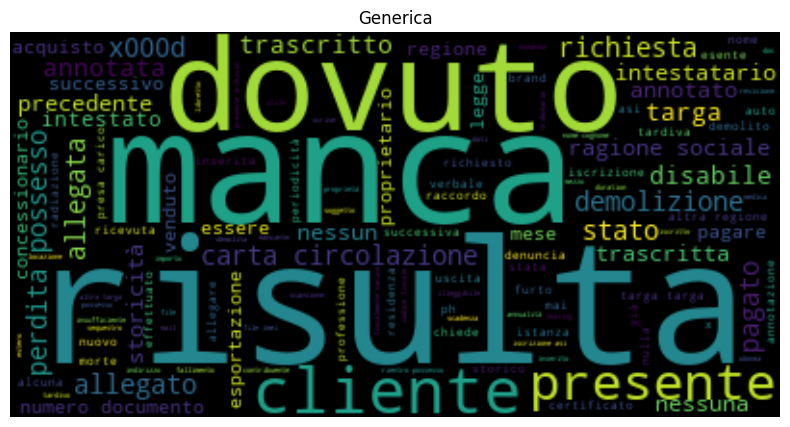

In [ ]:
df_cp = df.copy()


#concatenate every string within the same class
df_cp = df_cp.sort_values(by="CASISTICA_MOTIVAZIONE")
df_cp['NOTE_OPERATORE'] = df_cp['NOTE_OPERATORE'].apply(str)
df_cp["cat"] = df_cp.groupby(['CASISTICA_MOTIVAZIONE'])['NOTE_OPERATORE'].transform(lambda x : ' '.join(x))
df_cp["cat"] = df_cp["cat"].str.lower()


df_cp = remove_common_words(df_cp, top_n=15)

from wordcloud import WordCloud
class_name = "Generica"
df_cp = df_cp[df_cp["CASISTICA_MOTIVAZIONE"] == class_name]
print("Count: {}".format(df_cp.shape[0]))
wordcloud2 = WordCloud().generate(' '.join(df_cp['cat'].drop_duplicates().str.lower()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')  
plt.title(class_name)
plt.show()

['data', 'allega', 'bollo', 'versamento', 'esenzione', 'veicolo', 'atto', 'pagamento', 'pra', 'luogo', 'vendita', 'periodo', 'anno', 'documentazione', 'dichiara']
Count: 7


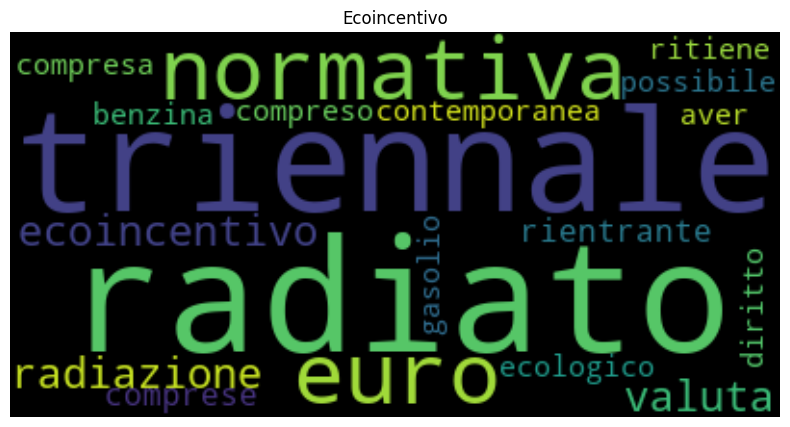

In [164]:
df_cp = df.copy()


#concatenate every string within the same class
df_cp = df_cp.sort_values(by="CASISTICA_MOTIVAZIONE")
df_cp['NOTE_OPERATORE'] = df_cp['NOTE_OPERATORE'].apply(str)
df_cp["cat"] = df_cp.groupby(['CASISTICA_MOTIVAZIONE'])['NOTE_OPERATORE'].transform(lambda x : ' '.join(x))
df_cp["cat"] = df_cp["cat"].str.lower()


df_cp = remove_common_words(df_cp, top_n=15)

from wordcloud import WordCloud
class_name = "Ecoincentivo"
df_cp = df_cp[df_cp["CASISTICA_MOTIVAZIONE"] == class_name]
print("Count: {}".format(df_cp.shape[0]))
wordcloud2 = WordCloud().generate(' '.join(df_cp['cat'].drop_duplicates().str.lower()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')  
plt.title(class_name)
plt.show()